In [1]:
# print pytorch cuda versioon
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))
import sys
print(sys.version)

2.1.2
True
11.8
8700
NVIDIA GeForce RTX 4070
3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]


In [1]:
import gc
from tqdm import tqdm
import torch
import torchaudio
import pandas
from faster_whisper import WhisperModel
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
def format_audio_list(audio_files, target_language="en", out_path=None, buffer=0.2, eval_percentage=0.15, speaker_name="coqui", gradio_progress=None):
    audio_total_size = 0
    # make sure that ooutput file exists
    os.makedirs(out_path, exist_ok=True)

    # print lenght of audio files
    print(f"Found {len(audio_files)} audio files!")

    # Loading Whisper
    device = "cuda" if torch.cuda.is_available() else "cpu" 
    # device = "cpu"
    print(f"Using {device} device")

    print("Loading Whisper Model!")
    asr_model = WhisperModel("large-v2", device=device, compute_type="float32")

    metadata = {"audio_file": [], "text": [], "speaker_name": []}

    if gradio_progress is not None:
        tqdm_object = gradio_progress.tqdm(audio_files, desc="Formatting...")
    else:
        tqdm_object = tqdm(audio_files)

    for audio_path in tqdm_object:
        print(audio_path)
        wav, sr = torchaudio.load(audio_path)
        # stereo to mono if needed
        if wav.size(0) != 1:
            wav = torch.mean(wav, dim=0, keepdim=True)

        wav = wav.squeeze()
        audio_total_size += (wav.size(-1) / sr)

        print(f"Transcribing {audio_path}...")
        print(torch.cuda.memory_allocated())
        print(torch.cuda.memory_reserved())
        segments, _ = asr_model.transcribe(audio_path, word_timestamps=True, language=target_language,)
        segments = list(segments)
        print(f"Found {len(segments)} segments!")
        i = 0
        sentence = ""
        sentence_start = None
        first_word = True
        # added all segments words in a unique list
        words_list = []
        for _, segment in enumerate(segments):
            words = list(segment.words)
            words_list.extend(words)

        # process each word
        for word_idx, word in enumerate(words_list):
            if first_word:
                sentence_start = word.start
                # If it is the first sentence, add buffer or get the begining of the file
                if word_idx == 0:
                    sentence_start = max(sentence_start - buffer, 0)  # Add buffer to the sentence start
                else:
                    # get previous sentence end
                    previous_word_end = words_list[word_idx - 1].end
                    # add buffer or get the silence midle between the previous sentence and the current one
                    sentence_start = max(sentence_start - buffer, (previous_word_end + sentence_start)/2)

                sentence = word.word
                first_word = False
            else:
                sentence += word.word

            if word.word[-1] in ["!", ".", "?"]:
                sentence = sentence[1:]
                # Expand number and abbreviations plus normalization
                audio_file_name, _ = os.path.splitext(os.path.basename(audio_path))

                audio_file = f"wavs/{audio_file_name}_{str(i).zfill(8)}.wav"

                # Check for the next word's existence
                if word_idx + 1 < len(words_list):
                    next_word_start = words_list[word_idx + 1].start
                else:
                    # If don't have more words it means that it is the last sentence then use the audio len as next word start
                    next_word_start = (wav.shape[0] - 1) / sr

                # Average the current word end and next word start
                word_end = min((word.end + next_word_start) / 2, word.end + buffer)
                
                absoulte_path = os.path.join(out_path, audio_file)
                os.makedirs(os.path.dirname(absoulte_path), exist_ok=True)
                i += 1
                first_word = True

                audio = wav[int(sr*sentence_start):int(sr*word_end)].unsqueeze(0)
                # if the audio is too short ignore it (i.e < 0.33 seconds)
                if audio.size(-1) >= sr/3:
                    torchaudio.save(absoulte_path,
                        audio,
                        sr
                    )
                else:
                    continue

                metadata["audio_file"].append(audio_file)
                metadata["text"].append(sentence)
                metadata["speaker_name"].append(speaker_name)

    df = pandas.DataFrame(metadata)
    df = df.sample(frac=1)
    num_val_samples = int(len(df)*eval_percentage)

    df_eval = df[:num_val_samples]
    df_train = df[num_val_samples:]

    df_train = df_train.sort_values('audio_file')
    train_metadata_path = os.path.join(out_path, "metadata_train.csv")
    df_train.to_csv(train_metadata_path, sep="|", index=False)

    eval_metadata_path = os.path.join(out_path, "metadata_eval.csv")
    df_eval = df_eval.sort_values('audio_file')
    df_eval.to_csv(eval_metadata_path, sep="|", index=False)

    # deallocate VRAM and RAM
    del asr_model, df_train, df_eval, df, metadata
    gc.collect()

    return train_metadata_path, eval_metadata_path, audio_total_size

def clear_gpu_cache():
    # clear the GPU cache

    if torch.cuda.is_available():
        print("Clearing GPU Cache...")
        torch.cuda.empty_cache()

c:\Users\tibed\anaconda3\envs\Research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
audio = torchaudio.load("dataset/wavs/Obama_speech_short_00000000.wav")

In [3]:
audioFile = "G:\\rp-tibedm\\audio\\Alan_Wake_Voice_Short.wav"
out_path = "G:\\rp-tibedm\\speechT5\\dataset"

train_metadata_path, eval_metadata_path, audio_total_size = format_audio_list([audioFile], out_path=out_path,
                                 target_language="en", buffer=0.2, speaker_name="alan_wake")

Found 1 audio files!
Using cuda device
Loading Whisper Model!


  0%|          | 0/1 [00:00<?, ?it/s]

G:\rp-tibedm\audio\Alan_Wake_Voice_Short.wav
Transcribing G:\rp-tibedm\audio\Alan_Wake_Voice_Short.wav...
0
0


100%|██████████| 1/1 [00:18<00:00, 18.38s/it]

Found 72 segments!


In [1]:
from datasets import load_dataset, Audio

df = load_dataset("audiofolder", data_dir="dataset/wavs", split="train")
# val = load_dataset("csv", data_files={"train": "dataset/metadata.csv"}, delimiter="|")

c:\Users\tibed\anaconda3\envs\Research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 71/71 [00:00<00:00, 140007.33it/s]
Generating train split: 70 examples [00:00, 2325.00 examples/s]


In [2]:
df = df.cast_column("audio", Audio(sampling_rate=16000))

In [3]:
df[0]

{'audio': {'path': 'G:\\rp-tibedm\\tts_models\\speechT5\\dataset\\wavs\\Alan_Wake_Voice_Short_00000000.wav',
  'array': array([-5.08993160e-11, -5.44124953e-11,  2.09053157e-11, ...,
         -2.86177790e-04, -2.43534188e-04, -2.10553364e-04]),
  'sampling_rate': 16000},
 'transcription': 'He was here in Bright Falls.',
 'speaker_id': 0.0}

In [4]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [5]:
tokenizer = processor.tokenizer

In [6]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name, 
    run_opts={"device": device}, 
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
c:\Users\tibed\anaconda3\envs\Research\lib\site-packages\speechbrain\utils\torch_audio_backend.py:22: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
c:\Users\tibed\anaconda3\envs\Research\lib\site-packages\speechbrain\utils\torch_audio_backend.py:22: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [7]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["transcription"],
        audio_target=audio["array"], 
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
processed_example = prepare_dataset(df[0])

In [9]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [10]:
tokenizer.decode(processed_example["input_ids"])

'He was here in Bright Falls.</s>'

In [11]:
processed_example["speaker_embeddings"].shape

(512,)

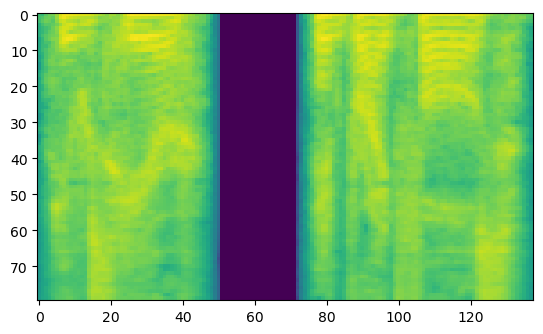

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [13]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [14]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [15]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [16]:
df = df.map(
    prepare_dataset, remove_columns=df.column_names,
)

In [17]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    # if input_length is greater than 100 and less than 25
    return 100 > input_length > 25
print(len(df))
df = df.filter(is_not_too_long, input_columns=["input_ids"])
print(len(df))

70
38


In [18]:
# check if every sample has a label
df = df.filter(lambda example: example["labels"] is not None)

Filter: 100%|██████████| 38/38 [00:00<00:00, 229.26 examples/s]


In [19]:
print(len(df))


38


In [20]:
df = df.train_test_split(test_size=0.1)

In [21]:
df

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 34
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 4
    })
})

In [22]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )        

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [23]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [26]:
features = [
    df["train"][0],
    df["train"][1],
    df["train"][20],
]

batch = data_collator(features)

In [27]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 88]),
 'attention_mask': torch.Size([3, 88]),
 'labels': torch.Size([3, 342, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

# training

In [28]:
model.config.use_cache = False

In [29]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    # push_to_hub=True,
)

In [30]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=df["train"],
    eval_dataset=df["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)


In [31]:
trainer.train()

  0%|          | 0/4000 [00:00<?, ?it/s]

c:\Users\tibed\anaconda3\envs\Research\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 8 but got size 64 for tensor number 1 in the list.